In [1]:
import os
os.chdir('/Users/sukhmac/Programming/FunCoding/Research/RLProgramming/GittenBandit')  # Set the correct path to your project root

In [22]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim.adam import Adam

from Environment.test_cases import test1, test2, test3
from Environment.mab_environment import Mab
from Strategies.strategy_interface import StrategyInterface
import matplotlib.pyplot as plt
from tqdm import tqdm

In [36]:
class PreferenceNonHomogeneousNN(nn.Module):
    '''
    Input R^2 : (k, n) : kth arm and nth state
    Output R^1 : preference or h[k][n]

    Usage :
    h = PreferenceNonHomogeneousNN()
    h(1,2)  # h[1][2] : returns tensor, do .item() for just the value.
    '''
    def __init__(self):
        super(PreferenceNonHomogeneousNN, self).__init__()
        self.layer1 = nn.Linear(2,4)
        self.layer2 = nn.Linear(4,2)
        self.layer3 = nn.Linear(2,1)
        self.R = nn.ReLU()
    def forward(self, k, n):
        x = torch.tensor([k, n], dtype=torch.float32)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x.squeeze()

class PreferenceHomogeneousNN(nn.Module):
    '''
    Input R : (n) : nth state
    Output R : preference or h[n]

    Usage :
    h = PreferenceHomogeneousNN()
    h(1)  # h[1] : returns tensor, do .item() for just the value.
    '''
    def __init__(self):
        super(PreferenceHomogeneousNN, self).__init__()
        self.layer1 = nn.Linear(1,3)
        self.layer2 = nn.Linear(3,3)
        self.layer3 = nn.Linear(3,2)
        self.layer4 = nn.Linear(2,1)
        self.R = nn.ReLU()
    def forward(self, n):
        x = torch.tensor([n], dtype=torch.float32)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.R(self.layer3(x))
        x = self.layer4(x)
        return x.squeeze()

In [45]:
class NeuralReinforce(StrategyInterface):
    def __init__(self, 
                 num_arms,
                 num_states_per_arm, 
                 homogeneous,
                 discount_factor, 
                 episode_len, 
                 learning_rate,
                 max_temperature, 
                 schedule):
        super().__init__("NeuralReinforce")
        self.k = num_arms
        self.n = num_states_per_arm
        self.discount_factor = discount_factor
        self.episode_len = episode_len
        self.learning_rate = learning_rate
        
        self.schedule = schedule  # implemented = ["linear"]
        if self.schedule == "linear":
            self.min_t = 0.5  # temperature
            self.max_t = max_temperature
            self.cur_t = self.max_t
            self.beta = 0.992

        self.homogeneous = homogeneous
        if self.homogeneous:
            self.h = PreferenceHomogeneousNN()  # preference for each state
        else:
            self.h = PreferenceNonHomogeneousNN()   # preference for each (k, n), i.e. kth arm and nth state

        self.optimizer = Adam(self.h.parameters(), lr=self.learning_rate)

    def get_action(self, cur_state):
        '''
        Using Boltzmann Sampling
        cur_states : state of each arm : np.array((k), dtype=int)
        '''
        action_probability = np.zeros((self.k))  # probability of selecting each arm
        
        if self.homogeneous:
            total = sum([np.exp(self.h(cur_state[i]).item()/self.cur_t) for i in range(self.k)])
            for i in range(self.k):
                action_probability[i] = np.exp(self.h(cur_state[i]).item()/self.cur_t) / total
        else:
            total = sum([np.exp(self.h(i, cur_state[i]).item()/self.cur_t) for i in range(self.k)])
            for i in range(self.k):
                action_probability[i] = np.exp(self.h(i, cur_state[i]).item()/self.cur_t) / total
                
        action = int(np.random.choice(range(self.k), p=action_probability))

        return action, action_probability

    def update(self, 
               cur_state,
               action_taken,
               action_probability,
               reward, 
               cumm_reward,
               cur_time):
        # update preferences
        if self.homogeneous:
            self.optimizer.zero_grad()
            loss = torch.tensor([0], dtype=torch.float32)
            for i in range(self.k):
                if i == action_taken:
                    loss += torch.tensor([1 - action_probability[i]], dtype=torch.float32) * self.h(cur_state[i])
                else:
                    loss += torch.tensor([- action_probability[i]], dtype=torch.float32) * self.h(cur_state[i])
            loss *= -(self.discount_factor**cur_time
                      * cumm_reward
                      * 1/self.cur_t)
            loss.backward()
            self.optimizer.step() 
        else:
            self.optimizer.zero_grad()
            loss = torch.tensor([0], dtype=torch.float32)
            for i in range(self.k):
                if i == action_taken:
                    loss += torch.tensor([1 - action_probability[i]], dtype=torch.float32) * self.h(i, cur_state[i])
                else:
                    loss += torch.tensor([- action_probability[i]], dtype=torch.float32) * self.h(i, cur_state[i])
            loss *= -(self.discount_factor**cur_time
                      * cumm_reward 
                      * 1/self.cur_t)
            loss.backward()
            self.optimizer.step()

        # update temperature
        if self.schedule == "linear":
            self.cur_t = self.min_t + self.beta * (self.cur_t - self.min_t)

        return

    def reset(self):
        if self.homogeneous:
            self.h = PreferenceHomogeneousNN()
        else:
            self.h = PreferenceNonHomogeneousNN()
     
        # As the model parameter "id" is changed, optimizer needs to be reinitialzed too.
        self.optimizer = Adam(self.h.parameters(), lr=self.learning_rate)

        if self.schedule == "linear":
            self.cur_t = self.max_t
            
        return

    def visualize_h_average(self, h_average, homogeneous, title, savepath):
        if self.homogeneous:
            # Plot all k x n variables on the same figure
            for i in range(self.n):
                plt.plot(h_average[:, i], label=f'h[{i}]')
                plt.text(h_average.shape[0]-1, h_average[:, i][-1], f'({i})', 
                             fontsize=8, verticalalignment='bottom', horizontalalignment='left')
            plt.legend()
            plt.xlabel("episode")
            plt.ylabel("preference")
            plt.title(title)
            plt.savefig(savepath)
            plt.show()
        else:
            # Plot all k x n variables on the same figure
            for i in range(self.k):
                for j in range(self.n):
                    plt.plot(h_average[:, i, j], label=f'h[{i}][{j}]')
                    plt.text(h_average.shape[0]-1, h_average[:, i, j][-1], f'({i},{j})', 
                             fontsize=8, verticalalignment='bottom', horizontalalignment='left')
            plt.legend()
            plt.xlabel("episode")
            plt.ylabel("preference")
            plt.title(title)
            plt.savefig(savepath)
            plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.36s/#runs]


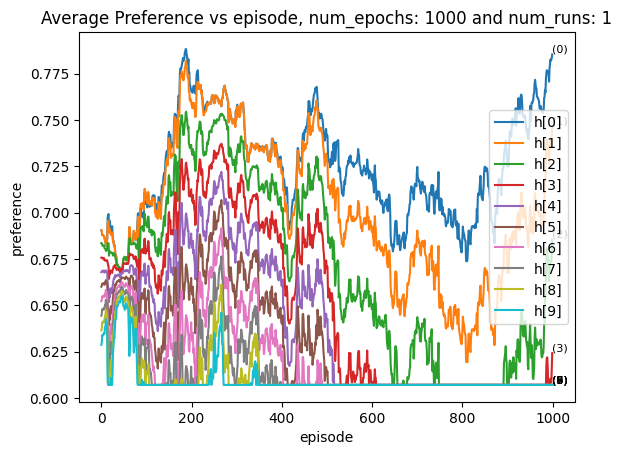

In [46]:
num_epochs = 1000
episode_len = 20
num_runs =1
learning_rate = 0.001
max_temperature = 400
test = test3
test_string = "test3"

mab = Mab(num_arms = test.num_arms,
          num_states_per_arm = test.num_states_per_arm,
          transition_matrices = test.transition_matrices,
          reward_matrices = test.reward_matrices,
          initial_start_state = test.initial_start_state,
          homogeneous = test.homogeneous)

nn_reinforce = NeuralReinforce(num_arms = test.num_arms,
                               num_states_per_arm = test.num_states_per_arm,
                               homogeneous=test.homogeneous,
                               discount_factor = test.discount_factor,
                               episode_len = episode_len, 
                               learning_rate = learning_rate,
                               max_temperature = max_temperature,
                               schedule="linear")

if mab.homogeneous:
    h_history = np.zeros((num_runs, num_epochs, mab.n))
    
    for run in tqdm(range(num_runs), unit="#runs"):
        nn_reinforce.reset()
        for epoch in range(num_epochs):
            mab.reset(random=True)
            state_history = np.zeros((episode_len, mab.k), dtype=int)
            action_history = np.zeros((episode_len), dtype=int)
            action_probability_history = np.zeros((episode_len, mab.k))
            reward_history = np.zeros((episode_len))
            
            # generate episode
            for t in range(episode_len):
                cur_state = mab.get_cur_state()
                action, action_probability = nn_reinforce.get_action(cur_state)
                _, reward = mab.step(action)
                
                state_history[t] = cur_state.copy()
                action_history[t] = action
                action_probability_history[t] = action_probability.copy()
                reward_history[t] = reward
    
            # Compute cumulative reward G_t for each time step
            G = 0
            return_history = np.zeros((episode_len))  # = \sum_t^T R_t
            for t, reward in enumerate(reversed(reward_history)):
                G = reward + test.discount_factor * G
                return_history[episode_len - t - 1] = G
        
            # update reinforce
            for t in range(episode_len):
                nn_reinforce.update(cur_state=state_history[t],
                                    action_taken=action_history[t],
                                    action_probability=action_probability_history[t],
                                    reward=reward_history[t], 
                                    cumm_reward=return_history[t],
                                    cur_time=t)
    
            # update h_history
            h = np.zeros((mab.n))
            for i in range(mab.n):
                 h[i] = nn_reinforce.h(i).item()
            h_history[run, epoch] = h.copy()
            
# Code for non-homogeneous
else:
    h_history = np.zeros((num_runs, num_epochs, mab.k, mab.n))
    
    for run in tqdm(range(num_runs), unit="#runs"):
        nn_reinforce.reset()
        for epoch in range(num_epochs):
            mab.reset(random=True)
            state_history = np.zeros((episode_len, mab.k), dtype=int)
            action_history = np.zeros((episode_len), dtype=int)
            action_probability_history = np.zeros((episode_len, mab.k))
            reward_history = np.zeros((episode_len))
            
            # generate episode
            for t in range(episode_len):
                cur_state = mab.get_cur_state()
                action, action_probability = nn_reinforce.get_action(cur_state)
                _, reward = mab.step(action)
                
                state_history[t] = cur_state.copy()
                action_history[t] = action
                action_probability_history[t] = action_probability.copy()
                reward_history[t] = reward
    
            # Compute cumulative reward G_t for each time step
            G = 0
            return_history = np.zeros((episode_len))  # = \sum_t^T R_t
            for t, reward in enumerate(reversed(reward_history)):
                G = reward + test.discount_factor * G
                return_history[episode_len - t - 1] = G
        
            # update reinforce
            for t in range(episode_len):
                nn_reinforce.update(cur_state=state_history[t],
                                    action_taken=action_history[t],
                                    action_probability=action_probability_history[t],
                                    reward=reward_history[t], 
                                    cumm_reward=return_history[t],
                                    cur_time=t)
    
            # update h_history
            h = np.zeros((mab.k, mab.n))
            for i in range(mab.k):
                for j in range(mab.n):
                    h[i][j] = nn_reinforce.h(i, j).item()
            h_history[run, epoch] = h.copy()

h_average = np.mean(h_history, axis=0)  # shape: (num_episode, k, n)
nn_reinforce.visualize_h_average(h_average,
                                 homogeneous=test.homogeneous,
                                 title=f"Average Preference vs episode, num_epochs: {num_epochs} and num_runs: {num_runs}",
                                 savepath=f"Results/NeuralReinforce/{test_string}_num_epochs={num_epochs}_num_runs={num_runs}_lr={learning_rate}_episode_len={episode_len}.png")